In [3]:
import cv2
import mediapipe as mp
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
# 두 node를 넣으면 벡터로 변환하여 리턴하는 함수
def makevector(pointA,pointB):
        #calculate vector between the two points (큰 노드에서 작은 노드로)
        vector = pointB-pointA
        return vector

# 두 vector data들의 cos 값 평균을 구하는 함수
def cos_sum(vectordata1, vectordata2):
    ls = [] #초기화
    for i in range(13):
        x = vectordata1[i]
        y = vectordata2[i]
        ls.append(check_degree(x,y))
        #print(check_degree(x,y))
        #cos = round(np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)),5)
        #ls.append( 1- (0.25*((cos+1)**2)) )  #0~1
              
    return sum(ls)/13

#두 벡터의 각도 차
def check_degree(i,j):
    x = np.dot(i,j ) / (np.linalg.norm(i) * np.linalg.norm(j))
    return math.degrees( math.acos( round(x,5) ))

In [5]:
# Loop over each frame of the video 
# 영상의 각 frame별 landmark들을 추출하여 리스트에 저장 (data1,data2)

def get_framedata(video_name): 

    # Load MediaPipe pose model
    mp_drawing = mp.solutions.drawing_utils
    mp_pose = mp.solutions.pose
    
    # Initialize the pose model
    pose1 = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    # Open the video file
    sample1 = cv2.VideoCapture(video_name)

    framedata1 = [] #total video1 vector data by frame

    print("extracting vector...   video:",video_name)
    
    while True:
        # Read a frame from the video
        ret1, frame1 = sample1.read()
        
        if not ret1:
            print("complete!")
            break
        
        # Convert the frame from BGR to RGB
        frame1.flags.writeable = False
        image1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)  
        # Run the pose model on the frame
        results1 = pose1.process(image1)
        
        if not results1.pose_landmarks:
            continue
            
        landmark1 = []
        
        for i in range(33):
            if i>0 and i<11: # 1,2,3,4,5,6,7,8,9,10 점 제외
                continue
            elif i>16 and i<23: # 17,18,19,20,21,22 점 제외
                continue
            elif i>28 and i<33: # 29,30,31,32 점 제외
                continue
            
            marki = results1.pose_landmarks.landmark[i]
            landmark1 += [(marki.x,marki.y,marki.z)]
            
        landmark1 = np.array(landmark1)

        #13개의 vector를 저장하는 lists
        vectordata1 = [] # video 1의 것

        #landmark1에 들어있는 점들로 벡터 만들어서 vectordata에 저장 (13개)
        vectordata1.append( makevector((landmark1[1] + landmark1[2])/2, landmark1[0]) )
        vectordata1.append( makevector(landmark1[5], landmark1[3]) )
        vectordata1.append( makevector(landmark1[3], landmark1[1]) )
        vectordata1.append( makevector(landmark1[2], landmark1[1]) )
        vectordata1.append( makevector(landmark1[4], landmark1[2]) )
        vectordata1.append( makevector(landmark1[6], landmark1[4]) )
        vectordata1.append( makevector(landmark1[8], landmark1[2]) )
        vectordata1.append( makevector(landmark1[7], landmark1[1]) )
        vectordata1.append( makevector(landmark1[8], landmark1[7]) )
        vectordata1.append( makevector(landmark1[10], landmark1[8]) )
        vectordata1.append( makevector(landmark1[12], landmark1[10]) )
        vectordata1.append( makevector(landmark1[11], landmark1[9]) )
        vectordata1.append( makevector(landmark1[9], landmark1[7]) )
        
        framedata1+= [vectordata1]

        # Draw the pose skeleton on the frame
        # mp_drawing.draw_landmarks(frame1, results1.pose_landmarks, mp_pose.POSE_CONNECTIONS,
        #                           mp_drawing.DrawingSpec(color=(255, 0, 0)),
        #                          mp_drawing.DrawingSpec(color=(0, 255, 0)))
        
        # mp_drawing.draw_landmarks(frame2, results2.pose_landmarks, mp_pose.POSE_CONNECTIONS,
        #                           mp_drawing.DrawingSpec(color=(255, 0, 0)),
        #                           mp_drawing.DrawingSpec(color=(0, 255, 0)))
        # Resize the frame
        # resized_frame1 = cv2.resize(frame1,(width1//4,height1//4))
        # resized_frame2 = cv2.resize(frame2,(width2//4,height2//4))

        # Show the frame
        # cv2.imshow("Video1", resized_frame1)
        # cv2.imshow("Video2", resized_frame2)
        
        # Wait for the user to press 'q' to exit
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break
        
    # Release the video file and close the window
    sample1.release()
    return framedata1

In [6]:
from fastdtw import fastdtw

framedata1 = get_framedata("sample4.mp4")
framedata2 = get_framedata("sample6.mp4")

dist_func = cos_sum
distance, path = fastdtw(framedata1, framedata2, dist= dist_func)

print("similarity:",round(100- (distance/len(path))/90*100,3),"%")
print(len(path))
print(path)

extracting vector...   video: sample4.mp4
complete!
extracting vector...   video: sample6.mp4
complete!
similarity: 81.147 %
302
[(0, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60), (1, 61), (1, 62), (1, 63), (1, 64), (1, 65), (1, 66), (1, 67), (1, 68), (1, 69), (1, 70), (1, 71), (1, 72), (1, 73), (1, 74), (1, 75), (1, 76), (1, 77), (1, 78), (1, 79), (1, 80), (1, 81), (1, 82), (1, 83), (1, 84), (1, 85), (1, 86), (1, 87), (1, 88), (1, 89), (1, 90), (1, 91), (1, 92), (1, 93), (1, 94), (1, 95), (1, 96), (1, 97)

In [21]:
ls = [i for i in path if cos_sum(framedata1[i[0]],framedata2[i[1]])]
print(ls)

[(1, 9), (1, 10), (1, 11), (1, 12), (1, 14), (1, 17), (1, 18), (1, 32), (1, 34), (1, 35), (1, 39), (1, 40), (1, 41), (1, 121), (1, 122), (1, 123), (1, 124), (1, 125), (1, 126), (1, 127), (1, 128), (1, 129), (1, 130), (1, 131), (1, 132), (1, 134), (1, 139), (1, 140), (1, 141), (1, 142), (1, 143), (1, 144), (1, 145), (1, 146), (1, 147), (1, 148), (2, 149), (3, 150), (4, 151), (5, 152), (6, 153), (7, 154), (7, 155), (8, 156), (9, 157), (10, 158), (11, 159), (11, 160), (12, 161), (13, 162), (14, 163), (15, 164), (16, 165), (16, 166), (17, 167), (18, 168), (19, 169), (19, 170), (20, 171), (21, 172), (22, 173), (23, 174), (24, 175), (24, 176), (25, 177), (26, 178), (27, 179), (27, 180), (28, 181), (29, 182), (30, 183), (31, 184), (31, 185), (32, 186), (33, 187), (34, 188), (35, 189), (36, 190), (36, 191), (37, 192), (38, 193), (39, 194), (39, 195), (40, 196), (41, 197), (42, 198), (43, 199), (43, 200), (44, 201), (45, 202), (46, 203), (47, 204), (47, 205), (48, 206), (49, 207), (50, 208), (5

In [18]:
print(path)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60), (1, 61), (1, 62), (1, 63), (1, 64), (1, 65), (1, 66), (1, 67), (1, 68), (1, 69), (1, 70), (1, 71), (1, 72), (1, 73), (1, 74), (1, 75), (1, 76), (1, 77), (1, 78), (1, 79), (1, 80), (1, 81), (1, 82), (1, 83), (1, 84), (1, 85), (1, 86), (1, 87), (1, 88), (1, 89), (1, 90), (1, 91), (1, 92), (1, 93), (1, 94), (1, 95), (1, 96), (1, 97), (1, 98), (1, 99), (1, 100), (1, 101), (1, 102), (1, 103), (1, 104), (1, 105), (1, 106), (1, 107), (1, 108), (1, 109), (1, 110),

extracting vector...   video: sample1.mp4
complete!
extracting vector...   video: sample1.mp4
complete!
similarity: 100.0 %
120
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 44), (45, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (87, 87), (88, 88), (

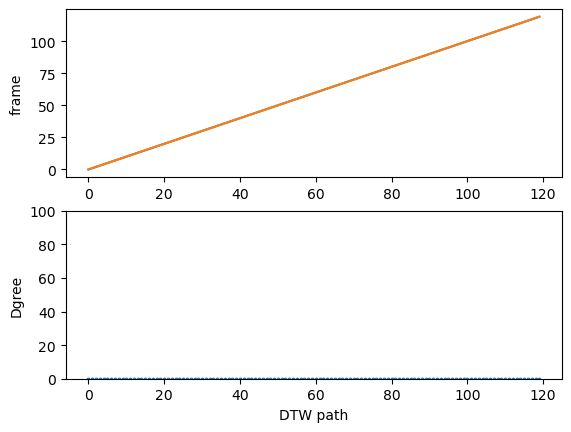

In [20]:
import matplotlib.pyplot as plt

from fastdtw import fastdtw

framedata1 = get_framedata("sample1.mp4") 
framedata2 = get_framedata("sample1.mp4") #sample과 다른 춤, 다른 사람 영상

dist_func = cos_sum
distance, path = fastdtw(framedata1, framedata2, dist= dist_func)
fig, axes = plt.subplots(2,1)

axes[0].plot(path)
axes[0].set_ylabel('frame')

ls = [cos_sum(framedata1[i[0]],framedata2[i[1]]) for i in path]
x = [i for i in range(len(path))]
axes[1].scatter(x,ls,s=3)
axes[1].set_ylim([0,100])
axes[1].set_ylabel('Dgree')
axes[1].set_xlabel('DTW path')

print("similarity:",round(100- (distance/len(path))/90*100,3),"%")
print(len(path))
print(path)

plt.show()

extracting vector...   video: sample1.mp4
complete!
extracting vector...   video: sample3.mp4
complete!
similarity: 56.859 %
344
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 60), (4, 61), (5, 62), (6, 63), (7, 64), (8, 65), (9, 66), (9, 67), (9, 68), (9, 69), (9, 70), (9, 71), (9, 72), (9, 73), (9, 74), (9, 75), (9, 76), (9, 77), (9, 78), (9, 79), (9, 80), (9, 81), (9, 82), (9, 83), (9, 84), (9, 85), (9, 86), (9, 87), (9, 88), (9, 89), (9, 90), (9, 91), (9, 92), (9, 93), (9, 94), (9, 95), (9, 96), (9, 97)

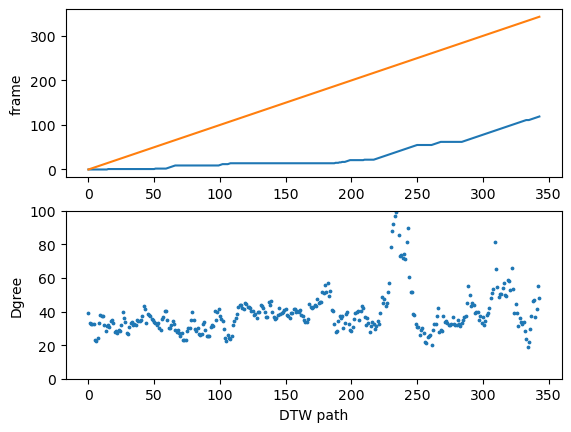

In [16]:
import matplotlib.pyplot as plt

from fastdtw import fastdtw

framedata1 = get_framedata("sample1.mp4") 
framedata2 = get_framedata("sample3.mp4") #sample과 다른 춤, 다른 사람 영상

dist_func = cos_sum
distance, path = fastdtw(framedata1, framedata2, dist= dist_func)
fig, axes = plt.subplots(2,1)

axes[0].plot(path)
axes[0].set_ylabel('frame')

ls = [cos_sum(framedata1[i[0]],framedata2[i[1]]) for i in path]
x = [i for i in range(len(path))]
axes[1].scatter(x,ls,s=3)
axes[1].set_ylim([0,100])
axes[1].set_ylabel('Dgree')
axes[1].set_xlabel('DTW path')

print("similarity:",round(100- (distance/len(path))/90*100,3),"%")
print(len(path))
print(path)

plt.show()

extracting vector...   video: sample1.mp4
complete!
extracting vector...   video: sample4.mp4
complete!
similarity: 71.154 %
136
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 42), (44, 43), (45, 44), (46, 45), (47, 46), (48, 47), (49, 48), (50, 49), (51, 50), (52, 51), (53, 52), (54, 53), (55, 54), (56, 55), (57, 56), (58, 57), (59, 58), (60, 59), (61, 60), (62, 61), (63, 62), (64, 63), (65, 64), (66, 65), (67, 66), (68, 67), (69, 68), (70, 69), (71, 70), (72, 71), (73, 72), (74, 73), (75, 74), (76, 75), (77, 76), (78, 77), (79, 78), (80, 79), (81, 80), (82, 81), (83, 82), (84, 83), (84, 84), (84, 85), (84, 86), (85, 87), 

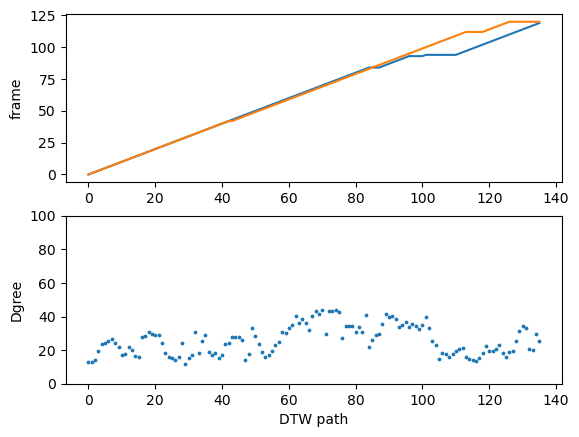

In [25]:
import matplotlib.pyplot as plt

from fastdtw import fastdtw

framedata1 = get_framedata("sample1.mp4") 
framedata2 = get_framedata("sample4.mp4") #sample과 같은 춤, 다른 사람 영상

dist_func = cos_sum
distance, path = fastdtw(framedata1, framedata2, dist= dist_func)
fig, axes = plt.subplots(2,1)

axes[0].plot(path)
axes[0].set_ylabel('frame')


ls = [cos_sum(framedata1[i[0]],framedata2[i[1]]) for i in path]
x = [i for i in range(len(path))]
axes[1].scatter(x,ls,s=3)
axes[1].set_ylim([0,100])
axes[1].set_ylabel('Dgree')
axes[1].set_xlabel('DTW path')

print("similarity:",round(100- (distance/len(path))/90*100,3),"%")
print(len(path))
print(path)

plt.show()

In [28]:
import matplotlib.pyplot as plt

from fastdtw import fastdtw

framedata1 = get_framedata("sample4.mp4")
framedata2 = get_framedata("sample6.mp4") # sample3 + sample4 

dist_func = cos_sum
distance, path = fastdtw(framedata1, framedata2, dist= dist_func)
fig, axes = plt.subplots(2,1)

axes[0].plot(path)
axes[0].set_ylabel('frame')

ls = [cos_sum(framedata1[i[0]],framedata2[i[1]]) for i in path]
x = [i for i in range(len(path))]
axes[1].scatter(x,ls,s=3)
axes[1].set_ylim([0,100])
axes[1].set_ylabel('Dgree')
axes[1].set_xlabel('DTW path')

print("similarity:",round(100- (distance/len(path))/90*100,3),"%")
print(len(path))
print(path)

plt.show()

extracting vector...   video: sample4.mp4
complete!
extracting vector...   video: sample6.mp4


extracting vector...   video: sample4.mp4
complete!
extracting vector...   video: sample5.mp4
complete!
similarity: 94.463 %
241
[(0, 0), (0, 1), (1, 2), (1, 3), (2, 4), (2, 5), (3, 6), (3, 7), (4, 8), (4, 9), (5, 10), (5, 11), (6, 12), (6, 13), (7, 14), (7, 15), (8, 16), (9, 17), (9, 18), (9, 19), (10, 20), (10, 21), (11, 22), (11, 23), (12, 24), (12, 25), (13, 26), (13, 27), (14, 28), (14, 29), (15, 30), (15, 31), (16, 32), (16, 33), (17, 34), (17, 35), (18, 36), (18, 37), (19, 38), (19, 39), (20, 40), (20, 41), (21, 42), (21, 43), (22, 44), (22, 45), (23, 46), (23, 47), (24, 48), (24, 49), (25, 50), (25, 51), (26, 52), (26, 53), (27, 54), (27, 55), (28, 56), (28, 57), (29, 58), (29, 59), (30, 60), (30, 61), (31, 62), (31, 63), (32, 64), (32, 65), (33, 66), (34, 67), (35, 68), (35, 69), (35, 70), (35, 71), (36, 72), (36, 73), (37, 74), (37, 75), (38, 76), (38, 77), (39, 78), (39, 79), (40, 80), (40, 81), (41, 82), (41, 83), (42, 84), (42, 85), (43, 86), (43, 87), (44, 88), (44, 89), 

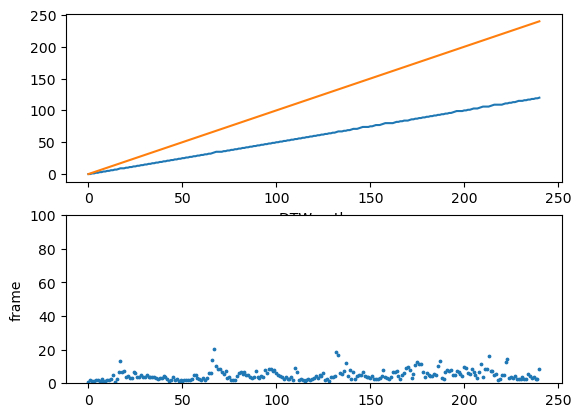

In [24]:
import matplotlib.pyplot as plt

from fastdtw import fastdtw

framedata1 = get_framedata("sample4.mp4")
framedata2 = get_framedata("sample5.mp4") #sample4 0.5 배속

dist_func = cos_sum
distance, path = fastdtw(framedata1, framedata2, dist= dist_func)
fig, axes = plt.subplots(2,1)

axes[0].plot(path)
axes[1].set_ylabel('frame')

ls = [cos_sum(framedata1[i[0]],framedata2[i[1]]) for i in path]
x = [i for i in range(len(path))]
axes[1].scatter(x,ls,s=3)
axes[1].set_ylim([0,100])
axes[1].set_ylabel('Dgree')
axes[1].set_xlabel('DTW path')

print("similarity:",round(100- (distance/len(path))/90*100,3),"%")
print(len(path))
print(path)

plt.show()

In [9]:
axes[1].set_ylim([0,100])
plt.show()

In [18]:
pose_connection = frozenset({#(0, 33),   #어떤 landmark 끼리 연결할지에 대한 정보
           #(12, 33),
           #(11, 33),
           (1,2),
           (3, 5),
           (1, 3),
           (2, 4),
           (4, 6),
           (2, 8),
           (1, 7),
           (7, 8),
           (7, 9),
           (9, 11),
           (8, 10),
           (10, 12),
           })

In [23]:
# Load MediaPipe pose model
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Initialize the pose model
pose1 = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
pose2 = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
# Open the video file
sample1 = cv2.VideoCapture("sample1.mp4")
sample2 = cv2.VideoCapture("sample4.mp4")

while True:
    # Read a frame from the video
    ret1, frame1 = sample1.read()
    ret2, frame2 = sample2.read()
    
    if not ret1 or not ret2:
        break


    # Convert the frame from BGR to RGB
    image1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

    # Run the pose model on the frame
    results1 = pose1.process(image1)
    results2 = pose2.process(image2)

    width1 = int(sample1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height1 = int(sample1.get(cv2.CAP_PROP_FRAME_HEIGHT))

    width2 = int(sample2.get(cv2.CAP_PROP_FRAME_WIDTH))
    height2 = int(sample2.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Draw the pose skeleton on the frame
    # a = results1.pose_landmarks.landmark
    # b = landmark_pb2.NormalizedLandmark
    # b.x= (a[11].x + a[12].x) /2
    # b.y= (a[11].y + a[12].y) /2
    # b.z= (a[11].z + a[12].z) /2
    # c = landmark_pb2.NormalizedLandmark()

    # results1.pose_landmarks.landmark.append(c)

    # a = results2.pose_landmarks.landmark
    # b = landmark_pb2.NormalizedLandmark
    # b.x= (a[11].x + a[12].x) /2
    # b.y= (a[11].y + a[12].y) /2
    # b.z= (a[11].z + a[12].z) /2
    # d = landmark_pb2.NormalizedLandmark()

    del results1.pose_landmarks.landmark[1:11] #delete unused landmarks
    del results2.pose_landmarks.landmark[1:11]

    del results1.pose_landmarks.landmark[7:13]
    del results2.pose_landmarks.landmark[7:13]

    del results1.pose_landmarks.landmark[13:17]
    del results2.pose_landmarks.landmark[13:17]

    #del results1.pose_landmarks.landmark[7:12]
    #del results2.pose_landmarks.landmark[7:12]

    mp_drawing.draw_landmarks(frame1, results1.pose_landmarks, pose_connection,
                                mp_drawing.DrawingSpec(color=(255, 0, 0)),
                                mp_drawing.DrawingSpec(color=(0, 255, 0)))

    mp_drawing.draw_landmarks(frame2, results2.pose_landmarks, pose_connection,
                                mp_drawing.DrawingSpec(color=(255, 0, 0)),
                                mp_drawing.DrawingSpec(color=(0, 255, 0)))

    #Resize the frame
    resized_frame1 = cv2.resize(frame1,(width1//2,height1//2))
    resized_frame2 = cv2.resize(frame2,(width2//2,height2//2))

    # Show the frame
    cv2.imshow("Video1", resized_frame1)
    cv2.imshow("Video2", resized_frame2)
    
    #Wait for the user to press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

#Wait for the user to press 'q' to exit
cv2.waitKey()           # 키가 입력될 때 까지 대기      
cv2.destroyAllWindows()  # 창 모두 닫기

# Release the video file and close the window
sample1.release()
sample2.release()

In [11]:
from mediapipe.framework.formats import landmark_pb2

a = landmark_pb2.NormalizedLandmark
print(a)
print(dir(a))

<class 'mediapipe.framework.formats.landmark_pb2.NormalizedLandmark'>
['ByteSize', 'Clear', 'ClearExtension', 'ClearField', 'CopyFrom', 'DESCRIPTOR', 'DiscardUnknownFields', 'Extensions', 'FindInitializationErrors', 'FromString', 'HasExtension', 'HasField', 'IsInitialized', 'ListFields', 'MergeFrom', 'MergeFromString', 'ParseFromString', 'RegisterExtension', 'SerializePartialToString', 'SerializeToString', 'SetInParent', 'UnknownFields', 'WhichOneof', '_CheckCalledFromGeneratedFile', '_SetListener', '__class__', '__deepcopy__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__unicode__', '_extensions_by_name', '_extensions_by_number', 'presence', 'visibility', 'x', 'y', 'z']


In [12]:
len(results1.pose_landmarks.landmark)

13

In [24]:
# Load MediaPipe pose model
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Initialize the pose model
pose1 = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
pose2 = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
# Open the video file
sample1 = cv2.VideoCapture("sample1.mp4")
sample2 = cv2.VideoCapture("sample4.mp4")

r = 0
while True:
    # Read a frame from the video
    ret1, frame1 = sample1.read()
    ret2, frame2 = sample2.read()

    r+=1
    if r==20:
        break


# Convert the frame from BGR to RGB
image1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

# Run the pose model on the frame
results1 = pose1.process(image1)
results2 = pose2.process(image2)

width1 = int(sample1.get(cv2.CAP_PROP_FRAME_WIDTH))
height1 = int(sample1.get(cv2.CAP_PROP_FRAME_HEIGHT))

width2 = int(sample2.get(cv2.CAP_PROP_FRAME_WIDTH))
height2 = int(sample2.get(cv2.CAP_PROP_FRAME_HEIGHT))

mp_drawing.draw_landmarks(frame1, results1.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(255, 0, 0)),
                            mp_drawing.DrawingSpec(color=(0, 255, 0)))

mp_drawing.draw_landmarks(frame2, results2.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(255, 0, 0)),
                            mp_drawing.DrawingSpec(color=(0, 255, 0)))

#Resize the frame
resized_frame1 = cv2.resize(frame1,(width1//2,height1//2))
resized_frame2 = cv2.resize(frame2,(width2//2,height2//2))

# Show the frame
cv2.imshow("Video1", resized_frame1)
cv2.imshow("Video2", resized_frame2)

#Wait for the user to press 'q' to exit
cv2.waitKey(1)

#Wait for the user to press 'q' to exit
cv2.waitKey()           # 키가 입력될 때 까지 대기      
cv2.destroyAllWindows()  # 창 모두 닫기

# Release the video file and close the window
sample1.release()
sample2.release()